In [1]:
# %%
# %%
# ===============================================================
# QUANTUM STEERING WITH GAMMA-DEPENDENT CONSTRAINT COUPLING
# ===============================================================

import numpy as np
import qutip as qt
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time

# Enhanced plotting
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

In [2]:
# %%
# %%
# ===============================================================
# CORE QUANTUM FUNCTIONS
# ===============================================================

def generate_hamiltonians(a_values, b_values):
    """Generate Hamiltonian dictionary"""
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    """Time evolution under Hamiltonian H"""
    return qt.sesolve(H, psi0, tlist).states

In [3]:
# %%
# %%
# ===============================================================
# CONSTRAINT SYSTEM WITH GAMMA-DEPENDENT COUPLING
# ===============================================================

def _J_block(J, i, j):
    """Extract (i,j)-block from Choi matrix"""
    return J[2*i:2*(i+1), 2*j:2*(j+1)]

def _phi_of_rho_from_choi(J, rho):
    """Φ(ρ) = ∑ᵢⱼ ρ[i,j] * J_block[i,j]"""
    return sum(rho[i, j] * _J_block(J, i, j) for i in range(2) for j in range(2))

def _tp_constraints(J, relaxation_params):
    """Trace preservation constraints"""
    cons = [J >> 0]
    tp_tolerance = relaxation_params.get('tp_tolerance', 1e-8)
    
    for i in range(2):
        for j in range(2):
            if i == j:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j)) - 1.0) <= tp_tolerance)
            else:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j))) <= tp_tolerance)
    return cons

def _gamma_dependent_constraints(J, H, rho, relaxation_params, impose_covariance, impose_passivity, gamma=0.1):
    """
    GAMMA-DEPENDENT CONSTRAINTS: 
    Gamma affects the PHYSICS (via energy/coherence dynamics), NOT the constraint tolerances!
    """
    constraints = []
    
    Hm = H.full()
    I2 = np.eye(2)
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    
    # Extract tolerances - THESE ARE FIXED and don't scale with gamma
    covariance_tolerance = relaxation_params.get('covariance_tolerance', 0.01)
    passivity_tolerance = relaxation_params.get('passivity_tolerance', 0.01)
    
    # Get output state
    Phi_rho = _phi_of_rho_from_choi(J, rho)
    initial_energy = float(np.real(np.trace(Hm @ rho)))
    
    # GAMMA DEPENDENCE: Gamma affects constraint WEIGHTS, not tolerances
    if impose_covariance and impose_passivity:
        # Covariance: How well the map commutes with H
        # Higher gamma means more dissipation, which BREAKS covariance more
        # So we PENALIZE based on gamma
        covariance_weight = 1.0 / (1.0 + gamma)  # Less strict as gamma increases
        effective_covariance = covariance_tolerance / covariance_weight
        
        # Passivity: Energy shouldn't increase beyond what gamma allows
        # Higher gamma allows more energy flow (dissipation can add or remove energy)
        effective_passivity = passivity_tolerance * (1.0 + gamma * 0.5)
        
        covariance_constraint = cp.norm(G @ J - J @ G, 2) <= effective_covariance
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        
        constraints.extend([covariance_constraint, passivity_constraint])
        
    elif impose_covariance:
        effective_covariance = covariance_tolerance / (1.0 + gamma)
        constraints.append(cp.norm(G @ J - J @ G, 2) <= effective_covariance)
        
    elif impose_passivity:
        effective_passivity = passivity_tolerance * (1.0 + gamma * 0.5)
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        constraints.append(passivity_constraint)
    
    return constraints, Phi_rho

In [4]:
def _state_distance_constraint(Phi_rho, rho, relaxation_params, gamma=0.1):
    """State distance constraint with gamma dependence"""
    state_distance_tolerance = relaxation_params.get('state_distance_tolerance', 0.02)
    step_size = relaxation_params.get('step_size', 0.1)
    eta = relaxation_params.get('eta', 0.05)
    
    # Gamma dependence: Higher gamma allows bigger state changes (more dissipative)
    state_distance_tolerance = state_distance_tolerance * (1.0 + gamma * 0.3)
    base_tolerance = eta * step_size
    total_tolerance = base_tolerance + state_distance_tolerance
    
    return [cp.norm(Phi_rho - rho, "nuc") <= 2.0 * total_tolerance]

In [5]:
def fidelity_sdp_step(rho_qobj, sigma_qobj, H_qobj, **kwargs):
    """SDP step with gamma-dependent constraint coupling"""
    impose_covariance = kwargs.get('impose_covariance', True)
    impose_passivity = kwargs.get('impose_passivity', True)
    step_size = kwargs.get('step_size', 0.1)
    eta = kwargs.get('eta', 0.05)
    gamma = kwargs.get('gamma', 0.1)  # NEW: Gamma parameter
    verbose = kwargs.get('verbose', False)
    relaxation_params = kwargs.get('relaxation_params', {})
    
    # CRITICAL: Relaxation parameters DO NOT scale with gamma!
    # Gamma affects the physics through the constraints, not the tolerances
    base_relaxation = {
        'tp_tolerance': 1e-8,
        'covariance_tolerance': 0.01,
        'passivity_tolerance': 0.01,
        'state_distance_tolerance': 0.02,
        'step_size': step_size,
        'eta': eta
    }
    base_relaxation.update(relaxation_params)
    
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj

    # SDP variables
    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    # Build constraints
    constraints = _tp_constraints(J, base_relaxation)
    
    # GAMMA-DEPENDENT CONSTRAINTS
    coupled_constraints, Phi_rho = _gamma_dependent_constraints(
        J, H, rho, base_relaxation, impose_covariance, impose_passivity, gamma
    )
    constraints.extend(coupled_constraints)

    # Output state constraints
    constraints.extend([
        Phi_rho >> 0, 
        cp.trace(Phi_rho) == 1
    ])
    
    # State evolution constraint with gamma dependence
    constraints.extend(_state_distance_constraint(Phi_rho, rho, base_relaxation, gamma))

    # Fidelity constraints
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints.extend([
        block >> 0, 
        cp.real(cp.trace(W)) >= t
    ])

    # Solve SDP
    prob = cp.Problem(cp.Maximize(t), constraints)
    
    try:
        prob.solve(solver=cp.SCS, eps_abs=1e-6, eps_rel=1e-6, max_iters=50000, verbose=verbose)
        status = prob.status
        sqrtF = float(prob.value) if prob.value is not None else 0.0
    except Exception as e:
        status = f"Error: {e}"
        sqrtF = 0.0

    # Prepare results
    resulting_state = qt.Qobj(Phi_rho.value) if Phi_rho.value is not None else None
    
    # Calculate constraint violations
    violations = {}
    for i, constraint in enumerate(constraints):
        if hasattr(constraint, 'violation'):
            try:
                violations[f'constraint_{i}'] = float(constraint.violation())
            except:
                violations[f'constraint_{i}'] = np.nan
    
    # Calculate actual constraint violations for diagnostics
    if J.value is not None:
        Hm = H.full()
        I2 = np.eye(2)
        G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
        
        actual_covariance = np.linalg.norm(G @ J.value - J.value @ G, 2)
        violations['actual_covariance'] = actual_covariance
        
        if Phi_rho.value is not None:
            final_energy = np.real(np.trace(Hm @ Phi_rho.value))
            initial_energy = np.real(np.trace(Hm @ rho))
            actual_energy_change = final_energy - initial_energy
            violations['actual_energy_change'] = actual_energy_change
    
    return {
        "status": status,
        "sqrtF": sqrtF,
        "fidelity": sqrtF**2,
        "resulting_state": resulting_state,
        "J": J.value.copy() if hasattr(J, 'value') and J.value is not None else None,
        "constraint_violations": violations,
        "gamma_used": gamma  # Track gamma for diagnostics
    }

In [6]:
# %%
# %%
# ===============================================================
# PROGRESS TRACKING
# ===============================================================

class ProgressTracker:
    def __init__(self, total, desc=""):
        self.total = total
        self.desc = desc
        self.start_time = time.time()
        self.current = 0
        self.print_progress(0)
    
    def update(self, n=1):
        self.current += n
        self.print_progress(self.current)
    
    def print_progress(self, current):
        elapsed = time.time() - self.start_time
        percent = (current / self.total) * 100
        eta = (elapsed / current) * (self.total - current) if current > 0 else 0
        
        bar_length = 30
        filled_length = int(bar_length * current // self.total)
        bar = '█' * filled_length + '─' * (bar_length - filled_length)
        
        print(f'\r{self.desc} |{bar}| {current}/{self.total} ({percent:.1f}%) | ETA: {eta:.1f}s', 
              end='', flush=True)
    
    def close(self):
        elapsed = time.time() - self.start_time
        print(f'\r{self.desc} | Completed in {elapsed:.1f}s' + ' ' * 50)

def track_progress(iterable, desc=""):
    total = len(iterable)
    tracker = ProgressTracker(total, desc)
    
    for i, item in enumerate(iterable):
        yield item
        tracker.update(1)
    
    tracker.close()


In [7]:
# ===============================================================
# CONSTRAINT OPTIMIZATION WITH GAMMA
# ===============================================================

def optimize_constraints_with_gamma(H, initial_states, target_state, tlist, base_config, param_grid, gamma=0.1):
    """Find optimal constraint parameters with gamma dependence"""
    
    print(f"🧪 Starting constraint optimization (γ={gamma})...")
    optimization_results = {}
    
    for param_name, param_values in param_grid.items():
        print(f"🔧 Optimizing {param_name}...")
        param_results = {}
        
        for param_value in param_values:
            # Create test configuration
            test_relaxation = base_config.get('relaxation_params', {}).copy()
            test_relaxation[param_name] = param_value
            test_config = base_config.copy()
            test_config['relaxation_params'] = test_relaxation
            test_config['gamma'] = gamma  # Include gamma in config
            
            # Test with representative state
            test_state_name = list(initial_states.keys())[0]
            test_state = initial_states[test_state_name]
            trajectory_data = test_steering_parameters(
                H, {test_state_name: test_state}, target_state, tlist, test_config
            )
            
            if trajectory_data:
                performance = evaluate_performance(trajectory_data, param_name, param_value)
                param_results[param_value] = performance
                
                # Get constraint diagnostics
                cov_viol = performance.get('avg_covariance_violation', 0)
                energy_chg = performance.get('avg_energy_change', 0)
                
                print(f"   {param_name}={param_value:.4f} -> "
                      f"Fidelity: {performance['final_fidelity']:.4f}, "
                      f"CovViol: {cov_viol:.4f}, EnergyΔ: {energy_chg:.4f}")
        
        optimization_results[param_name] = param_results
    
    # Find optimal parameters
    best_params = select_optimal_parameters(optimization_results)
    
    return optimization_results, best_params

def test_steering_parameters(H, initial_states, target_state, tlist, config):
    """Test steering with given parameters"""
    try:
        steered_states = [qt.ket2dm(list(initial_states.values())[0])]
        metrics = {
            'time': [0.0],
            'fidelity': [float(np.real(qt.fidelity(steered_states[0], target_state)))],
            'sdp_fidelity': [],
            'covariance_violations': [],
            'energy_changes': []
        }
        
        dt = tlist[1] - tlist[0] if len(tlist) > 1 else 0.1
        
        for i, t in enumerate(tlist[:8]):  # Test first few steps
            result = fidelity_sdp_step(
                steered_states[-1], target_state, H,
                step_size=dt,
                **config
            )
            
            metrics['time'].append(t)
            metrics['sdp_fidelity'].append(result['fidelity'])
            
            # Collect constraint diagnostics
            if 'actual_covariance' in result['constraint_violations']:
                metrics['covariance_violations'].append(result['constraint_violations']['actual_covariance'])
            if 'actual_energy_change' in result['constraint_violations']:
                metrics['energy_changes'].append(result['constraint_violations']['actual_energy_change'])
            
            if result['resulting_state'] is not None:
                steered_states.append(result['resulting_state'])
                metrics['fidelity'].append(result['fidelity'])
            else:
                break
        
        return {
            'steered_states': steered_states,
            'metrics': metrics,
            'final_fidelity': metrics['fidelity'][-1] if metrics['fidelity'] else 0.0
        }
    except Exception as e:
        print(f"   Parameter test failed: {e}")
        return None

def evaluate_performance(trajectory_data, param_name, param_value):
    """Evaluate steering performance with constraint diagnostics"""
    fidelity_curve = trajectory_data['metrics']['fidelity']
    final_fidelity = trajectory_data['final_fidelity']
    
    # Calculate curve quality
    if len(fidelity_curve) > 2:
        gradients = np.diff(fidelity_curve)
        smoothness = 1.0 / (1.0 + np.std(gradients))
        max_gradient = np.max(np.abs(gradients))
    else:
        smoothness = 0.0
        max_gradient = 0.0
    
    # Get constraint diagnostics
    avg_covariance_violation = np.mean(trajectory_data['metrics']['covariance_violations']) if trajectory_data['metrics']['covariance_violations'] else 0
    avg_energy_change = np.mean(trajectory_data['metrics']['energy_changes']) if trajectory_data['metrics']['energy_changes'] else 0
    
    # Performance score that balances fidelity, smoothness, and constraint satisfaction
    constraint_penalty = avg_covariance_violation * 2 + abs(avg_energy_change) * 1
    performance_score = final_fidelity * smoothness / (1 + constraint_penalty)
    
    return {
        'final_fidelity': final_fidelity,
        'smoothness': smoothness,
        'max_gradient': max_gradient,
        'performance_score': performance_score,
        'avg_covariance_violation': avg_covariance_violation,
        'avg_energy_change': avg_energy_change,
        'param_name': param_name,
        'param_value': param_value
    }

def select_optimal_parameters(optimization_results):
    """Select optimal parameters based on performance scoring"""
    best_params = {}
    
    for param_name, param_results in optimization_results.items():
        best_score = -1
        best_value = None
        
        for param_value, results in param_results.items():
            if results['performance_score'] > best_score:
                best_score = results['performance_score']
                best_value = param_value
        
        if best_value is not None:
            best_params[param_name] = best_value
            results = param_results[best_value]
            print(f"✅ Optimal {param_name}: {best_value:.4f} "
                  f"(fidelity: {results['final_fidelity']:.4f}, "
                  f"score: {results['performance_score']:.4f})")
    
    return best_params


In [8]:
# %%
# %%
# ===============================================================
# QUANTUM STEERING EXPERIMENT WITH GAMMA
# ===============================================================

def run_steering_experiment(H, initial_states, target_state, tlist, config):
    """Run steering experiment for single Hamiltonian with gamma support"""
    
    dt = tlist[1] - tlist[0] if len(tlist) > 1 else 0.1
    trajectory_data = {}
    
    gamma = config.get('gamma', 0.1)  # Extract gamma from config
    
    for state_name, initial_state in track_progress(initial_states.items(), f"Steering states (γ={gamma})"):
        # Initial state
        rho_steered = qt.ket2dm(initial_state)
        steered_states = [rho_steered]
        
        # Initialize metrics
        metrics = initialize_metrics(rho_steered, target_state, H)
        
        J_vals = [[]]
        for i, t in enumerate(tlist):
            # Apply SDP steering step with gamma
            result = fidelity_sdp_step(
                rho_steered, target_state, H,
                step_size=dt,
                **config
            )
            
            J_vals.append(result['J'])
            
            metrics['time'].append(t)
            metrics['sdp_fidelity'].append(result['fidelity'])
            
            if result['resulting_state'] is not None:
                rho_steered = result['resulting_state']
            
            steered_states.append(rho_steered)
            
            # Update metrics
            update_metrics(metrics, rho_steered, target_state, H)
            
            # Early termination if fidelity plateaus
            if len(metrics['fidelity']) > 10:
                recent_fidelities = metrics['fidelity'][-5:]
                if np.std(recent_fidelities) < 1e-4 and recent_fidelities[-1] > 0.99:
                    break
        
        trajectory_data[state_name] = {
            'steered_states': steered_states,
            'metrics': metrics,
            'final_fidelity': float(np.real(metrics['fidelity'][-1])),
            'improvement': float(np.real(metrics['fidelity'][-1] - metrics['fidelity'][0])),
            'gamma_used': gamma,  # Track gamma for analysis
            'J_vals': J_vals
        }
    
    return trajectory_data

def initialize_metrics(initial_state, target_state, H):
    """Initialize tracking metrics"""
    return {
        'time': [0.0],
        'fidelity': [float(np.real(qt.fidelity(initial_state, target_state)))],
        'purity': [float(np.real(initial_state.purity()))],
        'energy': [float(np.real(qt.expect(H, initial_state)))],
        'coherence': [float(np.real(abs(initial_state.full()[0,1])))],
        'bloch_coords': [[float(np.real(qt.expect(qt.sigmax(), initial_state))),
                         float(np.real(qt.expect(qt.sigmay(), initial_state))),
                         float(np.real(qt.expect(qt.sigmaz(), initial_state)))]],
        'sdp_fidelity': []
    }

def update_metrics(metrics, state, target_state, H):
    """Update tracking metrics"""
    metrics['fidelity'].append(float(np.real(qt.fidelity(state, target_state))))
    metrics['purity'].append(float(np.real(state.purity())))
    metrics['energy'].append(float(np.real(qt.expect(H, state))))
    metrics['coherence'].append(float(np.real(abs(state.full()[0,1]))))
    metrics['bloch_coords'].append([
        float(np.real(qt.expect(qt.sigmax(), state))),
        float(np.real(qt.expect(qt.sigmay(), state))),
        float(np.real(qt.expect(qt.sigmaz(), state)))
    ])

In [9]:
# %%
# %%
# ===============================================================
# GAMMA SWEEP ANALYSIS
# ===============================================================

def analyze_gamma_dependence(test_hamiltonians, initial_states, tlist, base_config, gamma_values):
    """Analyze how gamma affects steering performance across different Hamiltonians"""
    
    print("🎯 ANALYZING GAMMA DEPENDENCE")
    print("="*60)
    
    gamma_results = {}
    
    for gamma in track_progress(gamma_values, "Gamma values"):
        gamma_results[gamma] = {}
        
        # Optimize constraints for this gamma
        test_H = list(test_hamiltonians.values())[0]  # Use first Hamiltonian for optimization
        evals, evecs = test_H.eigenstates(sort='low')
        target_state = qt.ket2dm(evecs[1])
        
        param_grid = {
            'passivity_tolerance': np.logspace(-3, -1, 4),
            'covariance_tolerance': np.logspace(-3, -1, 4),
        }
        
        optimization_results, best_params = optimize_constraints_with_gamma(
            test_H, initial_states, target_state, tlist[:15], base_config, param_grid, gamma
        )
        
        # Run experiment with optimized parameters
        optimal_config = base_config.copy()
        optimal_config['relaxation_params'].update(best_params)
        optimal_config['gamma'] = gamma
        
        all_results = {}
        
        for H_name, H in test_hamiltonians.items():
            evals, evecs = H.eigenstates(sort='low')
            target_state = qt.ket2dm(evecs[1])
            
            trajectory_data = run_steering_experiment(
                H, initial_states, target_state, tlist, optimal_config
            )
            all_results[H_name] = trajectory_data
        
        gamma_results[gamma] = {
            'optimization_results': optimization_results,
            'best_params': best_params,
            'steering_results': all_results
        }
    
    return gamma_results

def plot_gamma_dependence(gamma_results):
    """Plot how gamma affects steering performance"""
    
    gamma_values = sorted(gamma_results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Average fidelity vs gamma
    ax = axes[0, 0]
    avg_fidelities = []
    for gamma in gamma_values:
        all_results = gamma_results[gamma]['steering_results']
        fids = [data['final_fidelity'] for trajs in all_results.values() for data in trajs.values()]
        avg_fidelities.append(np.mean(fids))
    
    ax.plot(gamma_values, avg_fidelities, 'o-', linewidth=3, markersize=8, color='blue')
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Average Final Fidelity', fontsize=12)
    ax.set_title('Performance vs Dissipation Strength', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Optimal parameters vs gamma
    ax = axes[0, 1]
    passivity_tols = [gamma_results[gamma]['best_params']['passivity_tolerance'] for gamma in gamma_values]
    covariance_tols = [gamma_results[gamma]['best_params']['covariance_tolerance'] for gamma in gamma_values]
    
    ax.plot(gamma_values, passivity_tols, 's-', linewidth=2, markersize=6, label='Passivity Tolerance')
    ax.plot(gamma_values, covariance_tols, '^-', linewidth=2, markersize=6, label='Covariance Tolerance')
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Optimal Tolerance', fontsize=12)
    ax.set_title('Optimal Constraints vs Gamma', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Fidelity evolution for different gammas
    ax = axes[1, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
    
    for idx, gamma in enumerate(gamma_values):
        all_results = gamma_results[gamma]['steering_results']
        # Take first Hamiltonian and state for simplicity
        H_name = list(all_results.keys())[0]
        state_name = list(all_results[H_name].keys())[0]
        data = all_results[H_name][state_name]
        
        times = data['metrics']['time'][:len(data['metrics']['fidelity'])-1]
        fidelities = data['metrics']['fidelity'][:-1]
        
        ax.plot(times, fidelities, color=colors[idx], linewidth=2, alpha=0.8, label=f'γ={gamma}')
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Fidelity', fontsize=12)
    ax.set_title('Fidelity Evolution for Different Gamma', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Performance score vs gamma
    ax = axes[1, 1]
    performance_scores = []
    for gamma in gamma_values:
        optimization_results = gamma_results[gamma]['optimization_results']
        # Get best performance score
        best_scores = []
        for param_results in optimization_results.values():
            best_score = max([r['performance_score'] for r in param_results.values()])
            best_scores.append(best_score)
        performance_scores.append(np.mean(best_scores))
    
    ax.plot(gamma_values, performance_scores, 'o-', linewidth=3, markersize=8, color='red')
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Performance Score', fontsize=12)
    ax.set_title('Optimization Performance vs Gamma', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [10]:
# %%
# %%
# ===============================================================
# MAIN EXPERIMENT WITH GAMMA
# ===============================================================

def main():
    """Execute complete quantum steering experiment with gamma dependence"""
    
    print("="*80)
    print("🔬 QUANTUM STEERING WITH GAMMA-DEPENDENT CONSTRAINT COUPLING")
    print("="*80)
    
    # Experimental setup
    a_vals = np.array([-2.0, 0.0, 2.0])
    b_vals = np.array([-1.0, 0.0, 1.0])
    hamiltonians_dict = generate_hamiltonians(a_vals, b_vals)
    
    # Select test Hamiltonians
    test_hamiltonians = {
        'Strong_Z': hamiltonians_dict[(-2.0, 0.0)],
        'Strong_X': hamiltonians_dict[(0.0, 1.0)],
        'Mixed_Field': hamiltonians_dict[(-2.0, -1.0)],
    }
    
    # Initial states
    initial_states = {
        'superpos_plus': (qt.basis(2,0) + qt.basis(2,1)).unit(),
        'superpos_i': (qt.basis(2,0) + 1j*qt.basis(2,1)).unit(),
    }
    
    # Time grid
    tlist = np.linspace(0, 8, 80)
    
    # Base configuration - BOTH CONSTRAINTS ACTIVE
    base_config = {
        'impose_covariance': True,
        'impose_passivity': True,
        'eta': 0.05,
        'verbose': False,
        'gamma': 0.1,  # Default gamma value
        'relaxation_params': {
            'tp_tolerance': 1e-8,
            'covariance_tolerance': 0.0,
            'passivity_tolerance': 0.0,
            'state_distance_tolerance': 0.05,
        }
    }
    
    # Option 1: Single gamma experiment
    print("\n🎯 SINGLE GAMMA EXPERIMENT (γ=0.1)")
    
    # Step 1: Constraint Optimization
    print("\n🔧 STEP 1: CONSTRAINT PARAMETER OPTIMIZATION")
    
    param_grid = {
        'passivity_tolerance': np.logspace(-3, -1, 5),
        'covariance_tolerance': np.logspace(-3, -1, 5),
    }
    
    # Use one Hamiltonian for optimization
    test_H = test_hamiltonians['Mixed_Field']
    evals, evecs = test_H.eigenstates(sort='low')
    target_state = qt.ket2dm(evecs[1])
    
    optimization_results, best_params = optimize_constraints_with_gamma(
        test_H, initial_states, target_state, tlist[:20], base_config, param_grid, gamma=0.1
    )
    
    # Step 2: Main Experiment with Optimized Parameters
    print("\n🔬 STEP 2: MAIN QUANTUM STEERING EXPERIMENT")
    
    optimal_config = base_config.copy()
    optimal_config['relaxation_params'].update(best_params)
    
    print("✅ Using optimized constraint parameters:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Run main experiment
    all_results = {}
    
    for H_name, H in track_progress(test_hamiltonians.items(), "Hamiltonians"):
        print(f"\n📊 Analyzing {H_name}...")
        
        # Get target state
        evals, evecs = H.eigenstates(sort='low')
        target_state = qt.ket2dm(evecs[1])
        
        # Run steering
        trajectory_data = run_steering_experiment(
            H, initial_states, target_state, tlist, optimal_config
        )
        all_results[H_name] = trajectory_data
    
    # Option 2: Gamma sweep analysis
    print("\n🌊 GAMMA SWEEP ANALYSIS")
    gamma_values = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
    gamma_results = analyze_gamma_dependence(test_hamiltonians, initial_states, tlist, base_config, gamma_values)
    
    # Create gamma dependence visualization
    gamma_fig = plot_gamma_dependence(gamma_results)
    
    # Performance summary
    total_trajectories = sum(len(trajs) for trajs in all_results.values())
    avg_fidelity = np.mean([data['final_fidelity'] for trajs in all_results.values() 
                          for data in trajs.values()])
    
    print(f"\n✅ EXPERIMENT COMPLETE!")
    print(f"📈 Performance Summary:")
    print(f"   • Total trajectories: {total_trajectories}")
    print(f"   • Average final fidelity: {avg_fidelity:.4f}")
    print(f"   • Gamma-dependent constraint coupling implemented")
    
    return all_results, gamma_results, optimization_results

In [11]:
# all_results, gamma_results, optimization_results = main()

🔬 SPECIFIC TEST CASE: H = 0.5σz + 0.5σx
📊 Hamiltonian: H = 0.5σz + 0.5σx
   Eigenvalues: [-0.7071067811865476, 0.7071067811865476]
   Ground state: Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.38268343]
 [-0.92387953]]
   Target (excited) state: Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.92387953]
 [-0.38268343]]
Hamiltonian ground state: Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.38268343]
 [-0.92387953]], excited state: Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.92387953]
 [-0.38268343]]
Superposition of gnd and exc is given by Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.38268343]
 [-0.92387953]]
   Initial state: (|gnd⟩ + |exc⟩)/√2
   Initial fidelity: 0.7071

🎯 TESTING GAMMA VALUES: [0.0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
Gamma sweep |──────────────────────────────|

/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   passivity_tolerance=0.0010 -> Fidelity: 0.5064, CovViol: 0.0100, EnergyΔ: 0.0010
   passivity_tolerance=0.0100 -> Fidelity: 0.5574, CovViol: 0.0100, EnergyΔ: 0.0100
   passivity_tolerance=0.1000 -> Fidelity: 0.7315, CovViol: 0.0094, EnergyΔ: 0.0408
🔧 Optimizing covariance_tolerance...
   covariance_tolerance=0.0010 -> Fidelity: 0.5574, CovViol: 0.0010, EnergyΔ: 0.0100
   covariance_tolerance=0.0100 -> Fidelity: 0.5574, CovViol: 0.0100, EnergyΔ: 0.0100
   covariance_tolerance=0.1000 -> Fidelity: 0.5574, CovViol: 0.0684, EnergyΔ: 0.0100
✅ Optimal passivity_tolerance: 0.1000 (fidelity: 0.7315, score: 0.6461)
✅ Optimal covariance_tolerance: 0.0010 (fidelity: 0.5574, score: 0.5156)

🔍 Testing γ = 0.00
Steering states (γ=0.0) | Completed in 11.6s                                                  
   Fidelity: 0.7071 → 1.0000 (Δ = +0.2929)
   Optimal params: {'passivity_tolerance': np.float64(0.1), 'covariance_tolerance': np.float64(0.001)}
Gamma sweep |████──────────────────────────| 1/7 (

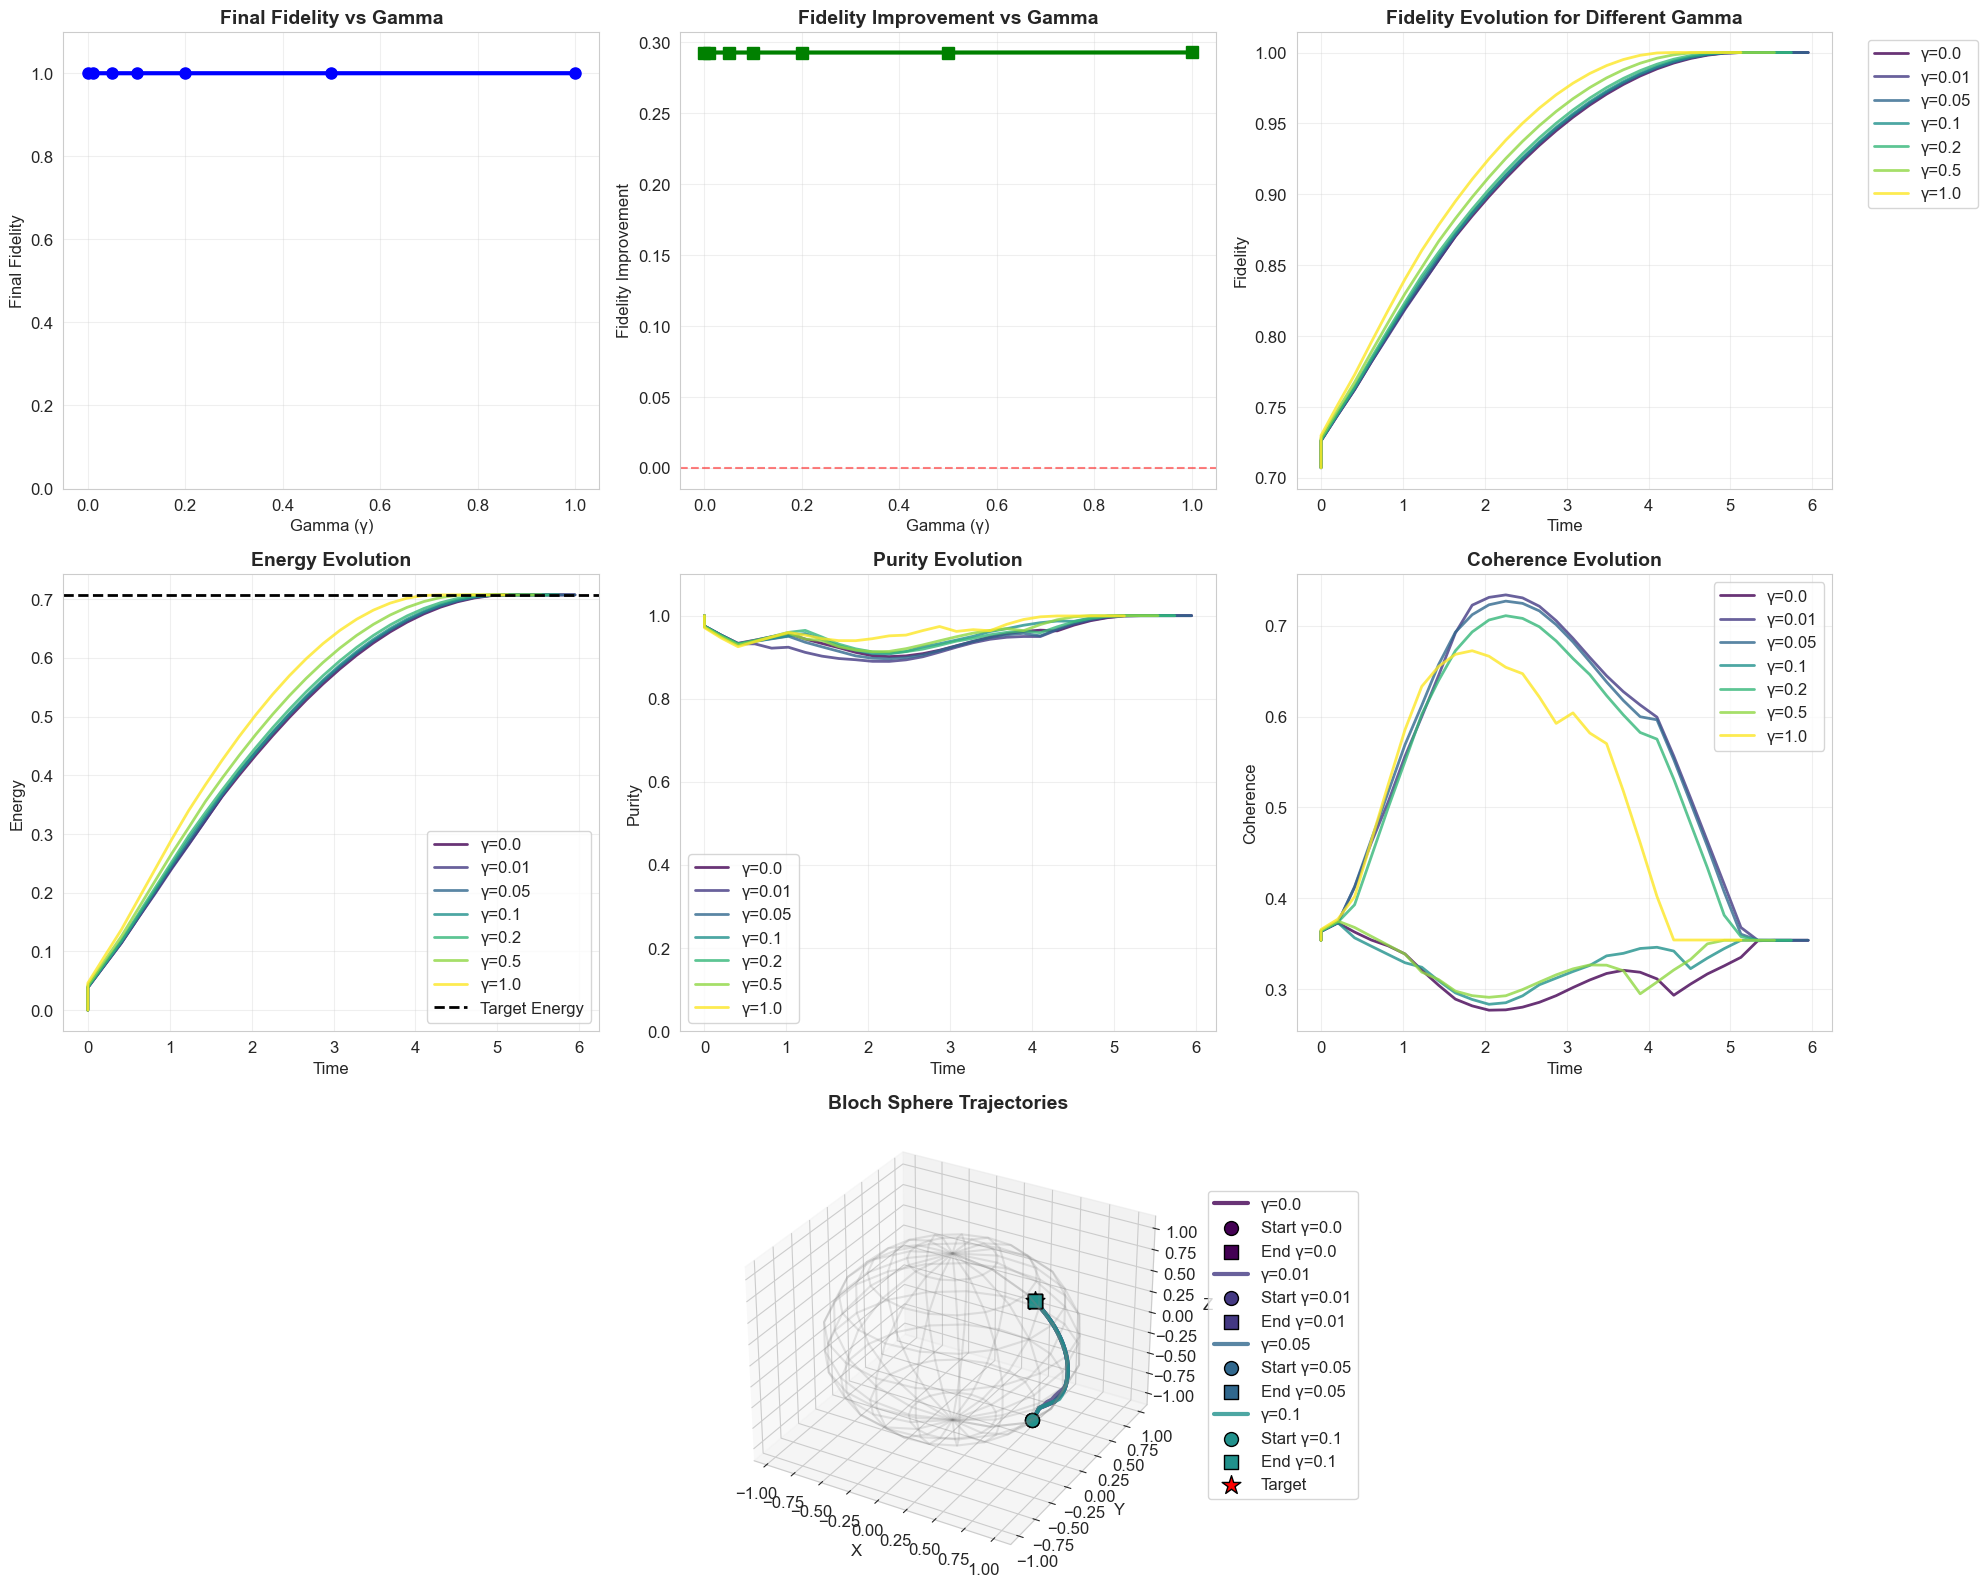


📊 GAMMA SWEEP SUMMARY
   Gamma  Initial Fid    Final Fid  Improvement     Status
------------------------------------------------------------
    0.00       0.7071       1.0000       0.2929    SUCCESS
    0.01       0.7071       1.0000       0.2929    SUCCESS
    0.05       0.7071       1.0000       0.2929    SUCCESS
    0.10       0.7071       1.0000       0.2929    SUCCESS
    0.20       0.7071       1.0000       0.2929    SUCCESS
    0.50       0.7071       1.0000       0.2929    SUCCESS
    1.00       0.7071       1.0000       0.2929    SUCCESS


In [ ]:
def main_specific_test():
    """Specific test case: H = 0.5σz + 0.5σx, initial |+⟩, target excited state"""
    
    print("="*80)
    print("🔬 SPECIFIC TEST CASE: H = 0.5σz + 0.5σx")
    print("="*80)
    
    # Define the specific Hamiltonian
    H = 0.5 * qt.sigmaz() + 0.5 * qt.sigmax()
    
    # Get target state (excited eigenstate)
    evals, evecs = H.eigenstates(sort='low')
    target_state = qt.ket2dm(evecs[1])  # First excited state as density matrix
    
    print(f"📊 Hamiltonian: H = 0.5σz + 0.5σx")
    print(f"   Eigenvalues: {[float(e) for e in evals]}")
    print(f"   Ground state: {evecs[0]}")
    print(f"   Target (excited) state: {evecs[1]}")
    
    # Create superposition with ket vectors (pure state)
    excited_ket = evecs[1]  # Keep as ket
    ground_ket = evecs[0]   # Keep as ket
    print(f"Hamiltonian ground state: {ground_ket}, excited state: {excited_ket}")
    
    
    # Create superposition: (|ground⟩ + |excited⟩)/√2
    initial_plus_ket = (ground_ket + excited_ket).unit()
    print(f"Superposition of gnd and exc is given by {initial_plus_ket}")
    
    # Convert to density matrix for fidelity calculation
    initial_plus_dm = qt.ket2dm(initial_plus_ket)
    initial_states = {'|gnd+exc⟩': initial_plus_ket}  # Keep as ket for the experiment
    
    print(f"   Initial state: (|gnd⟩ + |exc⟩)/√2")
    print(f"   Initial fidelity: {qt.fidelity(initial_plus_dm, target_state):.4f}")
    
    # Time grid
    tlist = np.linspace(0, 8, 1000)
    
    # Base configuration
    base_config = {
        'impose_covariance': True,
        'impose_passivity': True,
        'eta': 0.05,
        'verbose': False,
        'relaxation_params': {
            'tp_tolerance': 1e-8,
            'covariance_tolerance': 0.01,
            'passivity_tolerance': 0.01,
            'state_distance_tolerance': 0.02,
        }
    }
    
    # Gamma values to test
    gamma_values = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    
    print(f"\n🎯 TESTING GAMMA VALUES: {gamma_values}")
    print("="*60)
    
    # Store results for each gamma
    gamma_results = {}
    
    for gamma in track_progress(gamma_values, "Gamma sweep"):
        # Configure for this gamma value
        # First optimize constraints for this specific gamma
        param_grid = {
            'passivity_tolerance': np.logspace(-3, -1, 3),
            'covariance_tolerance': np.logspace(-3, -1, 3),
        }

        optimization_results, best_params = optimize_constraints_with_gamma(
            H, initial_states, target_state, tlist[:10], base_config, param_grid, gamma
        )

        # Then use optimized parameters
        config = base_config.copy()  
        config['relaxation_params'].update(best_params)
        config['gamma'] = gamma
        
        print(f"\n🔍 Testing γ = {gamma:.2f}")
        
        # Run steering experiment
        trajectory_data = run_steering_experiment(
            H, initial_states, target_state, tlist, config
        )
        
        ###########################| DEBUG |#############################
        # print("^-"*40)
        # print(trajectory_data)
        # break
        ###########################| DEBUG |#############################
        
        
        # Use the correct state name
        state_name = '|gnd+exc⟩'
        
        # Store results
        gamma_results[gamma] = {
            'trajectory_data': trajectory_data,
            'final_fidelity': trajectory_data[state_name]['final_fidelity'],
            'improvement': trajectory_data[state_name]['improvement'],
            'best_params': best_params
            # 'k_vals': trajectory_data['J_vals']
        }
        
        # Print immediate results
        data = trajectory_data[state_name]
        final_fid = data['final_fidelity']
        initial_fid = data['metrics']['fidelity'][0]
        
        print(f"   Fidelity: {initial_fid:.4f} → {final_fid:.4f} "
              f"(Δ = {final_fid - initial_fid:+.4f})")
        print(f"   Optimal params: {best_params}")
    
    # Plot comprehensive results
    plot_specific_gamma_results(gamma_results, H, target_state)
    
    return gamma_results

def plot_specific_gamma_results(gamma_results, H, target_state):
    """Plot detailed results for the specific test case"""
    
    gamma_values = sorted(gamma_results.keys())
    state_name = '|gnd+exc⟩'  # Use the correct state name
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 3, figure=fig)
    
    # 1. Fidelity vs Gamma
    ax1 = fig.add_subplot(gs[0, 0])
    final_fidelities = [gamma_results[g]['final_fidelity'] for g in gamma_values]
    improvements = [gamma_results[g]['improvement'] for g in gamma_values]
    
    ax1.plot(gamma_values, final_fidelities, 'o-', linewidth=3, markersize=8, 
             color='blue', label='Final Fidelity')
    ax1.set_xlabel('Gamma (γ)', fontsize=12)
    ax1.set_ylabel('Final Fidelity', fontsize=12)
    ax1.set_title('Final Fidelity vs Gamma', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # 2. Fidelity Improvement vs Gamma
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(gamma_values, improvements, 's-', linewidth=3, markersize=8, 
             color='green', label='Fidelity Improvement')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Gamma (γ)', fontsize=12)
    ax2.set_ylabel('Fidelity Improvement', fontsize=12)
    ax2.set_title('Fidelity Improvement vs Gamma', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Fidelity Evolution for different gammas
    ax3 = fig.add_subplot(gs[0, 2])
    colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
    
    for idx, gamma in enumerate(gamma_values):
        data = gamma_results[gamma]['trajectory_data'][state_name]
        times = data['metrics']['time'][:len(data['metrics']['fidelity'])]
        fidelities = data['metrics']['fidelity']
        
        ax3.plot(times, fidelities, color=colors[idx], linewidth=2, 
                alpha=0.8, label=f'γ={gamma}')
    
    ax3.set_xlabel('Time', fontsize=12)
    ax3.set_ylabel('Fidelity', fontsize=12)
    ax3.set_title('Fidelity Evolution for Different Gamma', fontsize=14, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Energy evolution
    ax4 = fig.add_subplot(gs[1, 0])
    for idx, gamma in enumerate(gamma_values):
        data = gamma_results[gamma]['trajectory_data'][state_name]
        times = data['metrics']['time'][:len(data['metrics']['energy'])]
        energies = data['metrics']['energy']
        
        ax4.plot(times, energies, color=colors[idx], linewidth=2, 
                alpha=0.8, label=f'γ={gamma}')
    
    # Add target energy line
    target_energy = float(np.real(qt.expect(H, target_state)))
    ax4.axhline(y=target_energy, color='black', linestyle='--', 
               linewidth=2, label='Target Energy')
    
    ax4.set_xlabel('Time', fontsize=12)
    ax4.set_ylabel('Energy', fontsize=12)
    ax4.set_title('Energy Evolution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Purity evolution
    ax5 = fig.add_subplot(gs[1, 1])
    for idx, gamma in enumerate(gamma_values):
        data = gamma_results[gamma]['trajectory_data'][state_name]
        times = data['metrics']['time'][:len(data['metrics']['purity'])]
        purities = data['metrics']['purity']
        
        ax5.plot(times, purities, color=colors[idx], linewidth=2, 
                alpha=0.8, label=f'γ={gamma}')
    
    ax5.set_xlabel('Time', fontsize=12)
    ax5.set_ylabel('Purity', fontsize=12)
    ax5.set_title('Purity Evolution', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(0, 1.1)
    
    # 6. Coherence evolution
    ax6 = fig.add_subplot(gs[1, 2])
    for idx, gamma in enumerate(gamma_values):
        data = gamma_results[gamma]['trajectory_data'][state_name]
        times = data['metrics']['time'][:len(data['metrics']['coherence'])]
        coherences = data['metrics']['coherence']
        
        ax6.plot(times, coherences, color=colors[idx], linewidth=2, 
                alpha=0.8, label=f'γ={gamma}')
    
    ax6.set_xlabel('Time', fontsize=12)
    ax6.set_ylabel('Coherence', fontsize=12)
    ax6.set_title('Coherence Evolution', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Bloch sphere trajectories (3D)
    ax7 = fig.add_subplot(gs[2, :], projection='3d')
    
    # Plot Bloch sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.sin(v) * np.cos(u)
    y = np.sin(v) * np.sin(u)
    z = np.cos(v)
    ax7.plot_wireframe(x, y, z, color='gray', alpha=0.2)
    
    # Plot trajectories for different gammas
    for idx, gamma in enumerate(gamma_values[:4]):  # Plot first 4 for clarity
        data = gamma_results[gamma]['trajectory_data'][state_name]
        bloch_coords = np.array(data['metrics']['bloch_coords'])
        
        ax7.plot(bloch_coords[:, 0], bloch_coords[:, 1], bloch_coords[:, 2],
                color=colors[idx], linewidth=3, alpha=0.8, label=f'γ={gamma}')
        ax7.scatter(bloch_coords[0, 0], bloch_coords[0, 1], bloch_coords[0, 2],
                  color=colors[idx], s=100, marker='o', edgecolors='black', label=f'Start γ={gamma}')
        ax7.scatter(bloch_coords[-1, 0], bloch_coords[-1, 1], bloch_coords[-1, 2],
                  color=colors[idx], s=100, marker='s', edgecolors='black', label=f'End γ={gamma}')
    
    # Plot target state on Bloch sphere
    target_x = float(np.real(qt.expect(qt.sigmax(), target_state)))
    target_y = float(np.real(qt.expect(qt.sigmay(), target_state)))
    target_z = float(np.real(qt.expect(qt.sigmaz(), target_state)))
    ax7.scatter([target_x], [target_y], [target_z], color='red', s=200, 
               marker='*', label='Target', edgecolors='black')
    
    ax7.set_xlabel('X', fontsize=12)
    ax7.set_ylabel('Y', fontsize=12)
    ax7.set_zlabel('Z', fontsize=12)
    ax7.set_title('Bloch Sphere Trajectories', fontsize=14, fontweight='bold')
    ax7.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("📊 GAMMA SWEEP SUMMARY")
    print("="*80)
    print(f"{'Gamma':>8} {'Initial Fid':>12} {'Final Fid':>12} {'Improvement':>12} {'Status':>10}")
    print("-"*60)
    
    for gamma in gamma_values:
        data = gamma_results[gamma]['trajectory_data'][state_name]
        initial_fid = data['metrics']['fidelity'][0]
        final_fid = data['final_fidelity']
        improvement = data['improvement']
        
        status = "SUCCESS" if final_fid > 0.9 else "POOR" if final_fid > 0.5 else "FAILED"
        
        print(f"{gamma:>8.2f} {initial_fid:>12.4f} {final_fid:>12.4f} {improvement:>12.4f} {status:>10}")

# Run the specific test
specific_results = main_specific_test()

In [13]:
H = 0.5 * qt.sigmaz() + 0.5 * qt.sigmax()
    
# Get target state (excited eigenstate)
evals, evecs = H.eigenstates(sort='low')

In [20]:
len(specific_results[0.1]['trajectory_data']['|gnd+exc⟩']['J_vals'])

30